In [1]:
import cell_movie_maker as cmm
import chaste_simulation_database_connector as csdc
import matplotlib.pyplot as plt
import numpy as np
import pathlib


from IPython.display import display
import IPython.display


cmm.Config.simulations_folder = pathlib.Path("chaste_output").resolve()
cmm.Config.output_folder = pathlib.Path("analysis_output").resolve()
# cmm.Config.set_simulation_database(pathlib.Path("analysis_output", "TCellABM.db"))

experiment = cmm.Experiment(pathlib.Path("chaste_output", "TCellABM"))
simulation = experiment.simulations[0]
sample_timepoint = simulation.timepoints[50]


# Visualisation Framework
The visualisation api is one of the more powerful uses.  
Here we will visualise raw simulation outputs, but importantly this can be combined with post-simulation analysis.  

## Overview
The design principle for visualisation is to have a plug and play system in which different plots or images can be easily dropped into a figure.  
We also want the framework to simplify what figures should be made (e.g. one plot per experiment / simulation / simulation timepoint).  
An common example is generating a plot for each timepoint, and stitch each plot together into a timelapse video.

The main class for visulisation is `AbstractSimulationVisualiser`, which is subclassed for specific visualisation tasks, and can be thought of as the blank canvas or figure.  
`Plotters` are a subsset of classes whose task is to generate a specific plot from some simulation data.  


Intentionally, there is a distinct separation between simulation data, visualisers and plotters.
This allows the conceptual separation of:
- `Visualisers` are blank canvases in which we combine `Plotters` (Intended to be as close to drag and drop as we can get in Python).  
- A configured `Visualiser` is similar to a pipeline (intentionally agnostic of simulation data)
- Multiple sets of simulation data can be passed through a visualiser to make multiple plots or movies.


## Example Basic Visualisation Workflow

Create basic tumour visualiser.  
By default, plots and movies will be written within `cmm.Config.output_folder`. However this can be configured for a specific visualiser.  

The `TumourSimulationVisualiser` is highly configurable (but poorly documented).  
Below is a demo

In [2]:
def postprocess(fig:plt.Figure, ax:plt.Axes|np.ndarray[plt.Axes], sim:cmm.Simulation, tp:cmm.SimulationTimepoint, frame_num:int):
    # Do some frame postprocessing
    pass

visualiser = cmm.visualisers.TumourSimulationVisualiser(visualisation_name='standard')
visualiser.figsize = (4,3)
visualiser.postprocess = postprocess

The key method which is overridden for specific visualisations is:
```(python)
AbstractSimulationVisualiser.visualise_frame(simulation:cmm.Simulation, timepoint:cmm.SimulationTimepoint, int:frame_number)
```

It is useful to check that we can plot a single frame:

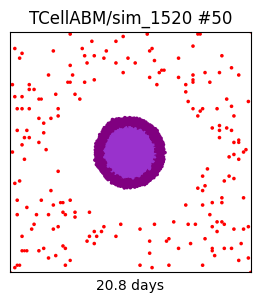

In [3]:
fig, ax = visualiser.visualise_frame(simulation, sample_timepoint, 50)
plt.show(fig)
plt.close(fig)

Since this worked fine, visualise every frame and stitch into a movie.

In [4]:
visualiser.visualise(simulation)
visualiser.create_ffcat(simulation, framerate=2)
visualiser.generate_mp4_from_ffcat(simulation, framerate=2)

100%|██████████| 101/101 [00:06<00:00, 16.31it/s]


/home/fann/Code/cell-movie-maker/examples/analysis_output/TCellABM/sim_1520/standard.ffcat


Video can be found in `analysis_output/TCellABM/sim_1520/standard.mp4`

## Visualise the Oxygen PDE

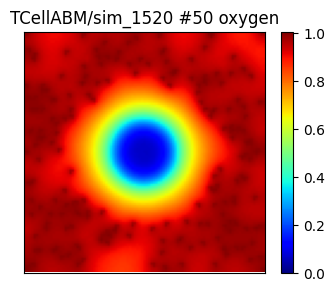

In [5]:
oxygen_visualiser = cmm.visualisers.ChemokineVisualiser(visualisation_name='oxygen', chemokine_name='oxygen')
oxygen_visualiser.figsize=(4,3)

fig, ax = oxygen_visualiser.visualise_frame(simulation, sample_timepoint, 50)
plt.show(fig)
plt.close(fig)

Single frame worked, now make a movie.  
Video can be found in `analysis_output/TCellABM/sim_1520/oxygen.mp4`.  

In [6]:
oxygen_visualiser.visualise(simulation)
oxygen_visualiser.create_ffcat(simulation, framerate=2)
oxygen_visualiser.generate_mp4_from_ffcat(simulation, framerate=2)

100%|██████████| 101/101 [00:03<00:00, 25.74it/s]


/home/fann/Code/cell-movie-maker/examples/analysis_output/TCellABM/sim_1520/oxygen.ffcat


## Custom Visualisation of Tumour and Oxygen
Create a custom Visualiser class.  
NOTE: For convenience it may be sensible to subclass from `SimulationVisualiser`, however this shows how easy it is to create a visualisation class from scratch.  


In [7]:
class CustomVisualiser(cmm.AbstractSimulationVisualiser):
    def __init__(self, visualisation_name="custom_plot", *args, **kwargs):
        # Simply forward arguments to parent, but change default visualisation_name
        super().__init__(visualisation_name=visualisation_name, **kwargs)
        # Create configs for the plotters we will use.
        # These config classes customise the plotters, e.g. colour schemes. We leave them at default values here
        self.plotter_config = cmm.plotters.TimepointPlotter.Config()
        self.oxygen_plotter_config = cmm.plotters.ChemokinePDETimepointPlotter.Config(chemokine='oxygen', cmap='plasma')

    def visualise_frame(self, sim:cmm.Simulation, tp:cmm.SimulationTimepoint, frame_num:int)->tuple[plt.Figure,np.ndarray[plt.Axes]]:
        fig, axs = plt.subplots(1,2, figsize=(10,4), gridspec_kw=dict(hspace=0, wspace=0))

        # Drop in Timepoint Plot
        cmm.plotters.TimepointPlotter.plot(fig, axs[0], tp, frame_num, tp.timestep, sim=sim, config=self.plotter_config)

        # Drop in Oxygen Plot
        cmm.plotters.ChemokinePDETimepointPlotter.plot(fig, axs[1], tp, frame_num, tp.timestep, sim=sim, config=self.oxygen_plotter_config)

        return fig, axs

That is all the code required to create a new visualiser.  
We can additionally postprocess the figure outside our new class.  
Check that we can plot a single frame.  

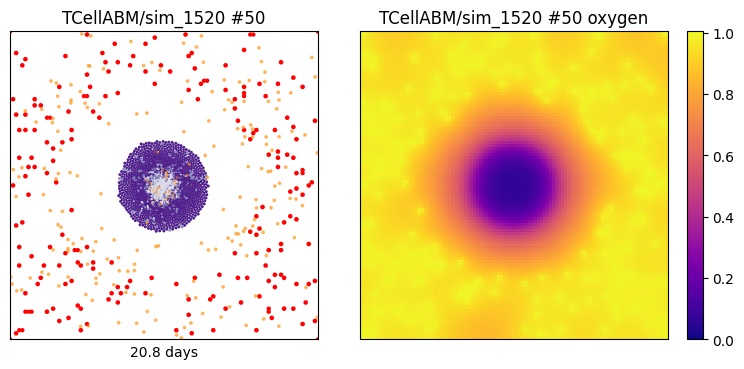

In [8]:
custom_visualiser = CustomVisualiser()

fig, ax = custom_visualiser.visualise_frame(simulation, sample_timepoint, 50)
plt.show(fig)
plt.close(fig)

We could use postprocessing to fix the plot titles (This could be done inside our custom class).  
NOTE: Postprocessing is not performed when calling `visualise_frame`, it is applied to each frame only when running `visualise` on multiple frames.  
(For details see `AbstractSimulationVisualiser._visualise_frame`).  
This could be changed, however the intention is that postprocessing is not needed when running `visualise_frame`, since the figure and axes are directly returned and editable.

In [9]:
def custom_postprocess(fig:plt.Figure, axs:np.ndarray[plt.Axes], sim:cmm.Simulation, tp:cmm.SimulationTimepoint, frame_num:int):
    axs[1].set_title('Oxygen PDE')
    axs[1].images[0].colorbar.set_label('oxygen')
    fig.tight_layout()
custom_visualiser.postprocess = custom_postprocess

custom_visualiser.visualise(simulation)
custom_visualiser.create_ffcat(simulation, framerate=2)
custom_visualiser.generate_mp4_from_ffcat(simulation, framerate=2)

100%|██████████| 101/101 [00:15<00:00,  6.44it/s]


/home/fann/Code/cell-movie-maker/examples/analysis_output/TCellABM/sim_1520/custom_plot.ffcat


Generated movie can be found in `analysis_output/TCellABM/sim_1520/custom_plot.mp4`

## Other visualisers that are useful (but less well written)

### Grid (and row) Visualiser
Visualise multiple simulations from a parameter sweep organized into a parameter grid.  
(And making movies of these grids)
e.g.  
![Example of Grid Visualisation](_demo_plots/Grid%20Visualisation.png "Example of Grid Visualisation")

### SVG Visualisers
There is a set of alternative (now legacy) mirror classes that plot cells by creating SVGs.  
This is faster than using matplotlib artists, however since switching to matplotlib collections there is no longer a significant speed increase.  

### Some custom precreated visualisers
There are various pre-created visualisers (mostly designed to work with TCellABM).  
